In [1]:
PROCESSED_PATH = '../data/processed/1_preprocessed.pkl'
FEATURE_SKILL_PATH = '../data/processed/features_skills_clusters.pkl'

target_col= ['DevType']
influnce_col = ['LanguageWorkedWith',
                  'DatabaseWorkedWith',
                  'WebframeWorkedWith',
                  'MiscTechWorkedWith',]

EXPORT_PATH    = "../data/processed/2_cleaned_data.pkl"


In [2]:
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import seaborn as sns
import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram



In [3]:
processed_df= pd.read_pickle(PROCESSED_PATH)
feature_skill =pd.read_pickle(FEATURE_SKILL_PATH)

In [4]:

encoded_dfs = {}
for col in target_col + influnce_col:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(processed_df[col]),
                               columns=binarizer.classes_,
                               index=processed_df[col].index)
    encoded_dfs[col] = encoded_df
    ohe_df = pd.concat(encoded_dfs, axis=1)

## Quick Sanity Check

In [5]:
i = np.random.randint(0, len(processed_df))
#check if the encoding is correct
print('Encoded data:')
print(ohe_df.loc[i,influnce_col][ohe_df.iloc[i] == 1])
print('------------------------------------')
#check if the original data is correct
print('\n Original data: ')
print(processed_df.iloc[i][influnce_col])
print('------------------------------------')

#check clustring
print('\n Clustring data: ')
print(f'Clusters : {feature_skill.iloc[i].sum()}')
print(f'Skills : {ohe_df.iloc[i][influnce_col].sum()}')




Encoded data:
LanguageWorkedWith  Python    1
                    R         1
Name: 58329, dtype: int32
------------------------------------

 Original data: 
LanguageWorkedWith    [Python, R]
DatabaseWorkedWith             []
WebframeWorkedWith             []
MiscTechWorkedWith             []
Name: 58329, dtype: object
------------------------------------

 Clustring data: 
Clusters : 2
Skills : 2


# EXclude Some Rules

In [6]:
# Exclude roles
EXCULDE_ROLES = [
    'Designer',
    'Educator',
    'Marketing or sales professional',
    'Engineering manager',
    'Product manager',
    'Engineer, site reliability',
    'Senior executive/VP',]

In [7]:
for role in EXCULDE_ROLES:
    ohe_df.drop(('DevType', role), axis=1,inplace=True)

# Filter Data

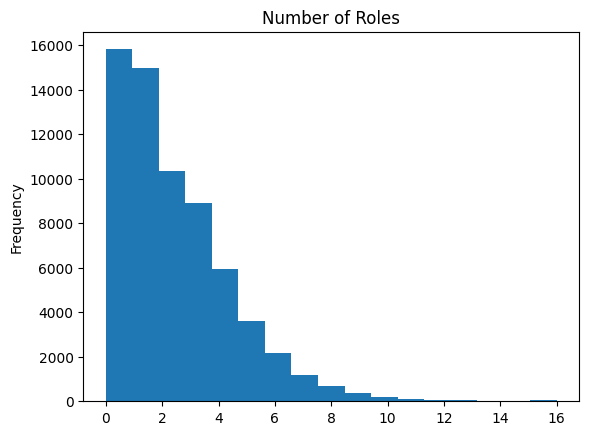

In [8]:
ohe_df['DevType'].sum(axis=1).sort_values(ascending=False).plot(kind='hist',bins=17)
plt.title('Number of Roles')
plt.show()

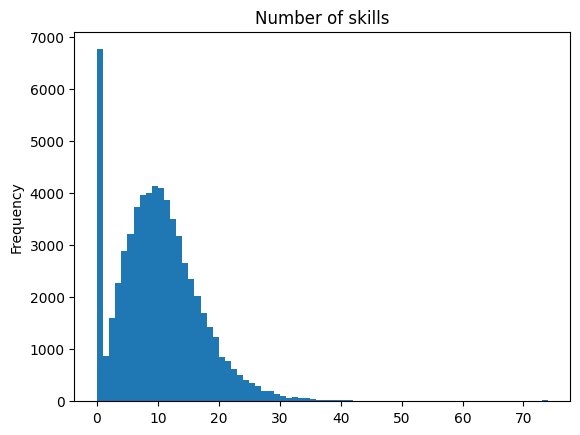

In [9]:
skills = ohe_df[influnce_col].sum(axis=1)
skills.plot(kind='hist',bins=skills.max())
plt.title('Number of skills')
plt.show()

In [10]:
role_range = [1,2]
skill_range = [3,12]

In [11]:
role_mask = ((ohe_df['DevType'].sum(axis=1) >= 1) & ((ohe_df['DevType'].sum(axis=1) <= 2)))
skill_mask =((ohe_df[influnce_col].sum(axis=1)>=3) & (ohe_df[influnce_col].sum(axis=1)<=12))
filter_mask = role_mask & skill_mask

In [12]:
feature_df = feature_skill[filter_mask].copy()
encode_df = ohe_df[filter_mask].copy()

In [13]:
feature_df.columns = pd.MultiIndex.from_product([['skills_clusters'], 
                                                  feature_df.columns])

In [14]:
df = pd.concat([feature_df, encode_df], axis=1)

In [15]:
df.to_pickle(EXPORT_PATH)